In [1]:
from CNN import CNN
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import set_random_seed, image_dataset_from_directory
import os
import tensorflow as tf
from utils import prepare_dataset, plot_confusionMatrix, plot_history
import numpy as np

In [2]:
SEED = 42
DATASET_PATH = "../../../dataset/"
EPOCHS = 150
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
INPUT_SHAPE = (224, 224, 3, )

In [3]:
model_path = "./trained_cnn/"
cnn = CNN(model_path)
cnn.cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 42, 42, 256)       73984     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 21, 21, 256)      0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 19, 19, 64)        147520    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 9, 9, 64)        

## Train Val Test best model

In [3]:
# Load the training dataset
print("Loading train dataset...")
train_dataset = image_dataset_from_directory(
    directory=os.path.join(DATASET_PATH, "train"),
    label_mode="categorical",
    validation_split=None,
    image_size=(224, 224),
    batch_size=None,
    seed=SEED
    )
print("Train dataset loaded!")
print("Labels in the dataset: ", train_dataset.class_names)

# Load the validation dataset
print("Loading validation dataset...")
val_dataset = image_dataset_from_directory(
    directory=os.path.join(DATASET_PATH, "valid"),
    label_mode="categorical",
    validation_split=None,
    image_size=(224, 224),
    batch_size=None,
    seed=SEED
    )
print("Validation dataset loaded!")

test_ds = image_dataset_from_directory(
        directory=os.path.join(DATASET_PATH, "test"),
        label_mode="categorical",
        validation_split=None,
        image_size=(224, 224),
        batch_size=None,
        seed=SEED
        )
X_test, y_test = [], []
for image, label in test_ds:
    image /= 255.
    X_test.append(image.numpy())
    y_test.append(label.numpy())
X_test = tf.convert_to_tensor(np.asarray(X_test, dtype='float32'))
y_test = np.asarray(y_test, dtype='float32')
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

train_ds = prepare_dataset(train_dataset, SEED, AUTOTUNE, BATCH_SIZE, augment=False)
val_ds = prepare_dataset(val_dataset, SEED, AUTOTUNE, BATCH_SIZE)

len(train_ds), len(val_ds)

Loading train dataset...
Found 11280 files belonging to 2 classes.
Train dataset loaded!
Labels in the dataset:  ['savory', 'unsavory']
Loading validation dataset...
Found 600 files belonging to 2 classes.
Validation dataset loaded!
Found 600 files belonging to 2 classes.


(353, 19)

In [4]:
early_stopping = EarlyStopping(monitor="val_loss", patience=12, min_delta=0.0001, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
callbacks = [early_stopping, lr_scheduler]

In [7]:
best_model_path = "../CNN_training/keras_tuner/"
history = CNN(model_path).get_best_model(best_model_path).fit(train_ds, epochs=50, callbacks=callbacks, validation_data=val_ds)

KDTree computed in: 1.1999999998124622e-06
INFO:tensorflow:Reloading Oracle from existing project ../CNN_training/keras_tuner/tuned_model\oracle.json
INFO:tensorflow:Reloading Tuner from ../CNN_training/keras_tuner/tuned_model\tuner0.json
Epoch 1/50
353/353 [==============================] - 41s 96ms/step - loss: 1.2073 - accuracy: 0.6189 - val_loss: 0.8247 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 2/50
353/353 [==============================] - 24s 69ms/step - loss: 0.6340 - accuracy: 0.7134 - val_loss: 1.0831 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 3/50
353/353 [==============================] - 24s 68ms/step - loss: 0.5540 - accuracy: 0.7644 - val_loss: 1.6523 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 4/50
353/353 [==============================] - 24s 68ms/step - loss: 0.5328 - accuracy: 0.7738 - val_loss: 1.5925 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 5/50
353/353 [==============================] - 24s 69ms/step - loss: 0.5240 - accuracy: 0.7796 - val_loss: 0.9566 - val_accura

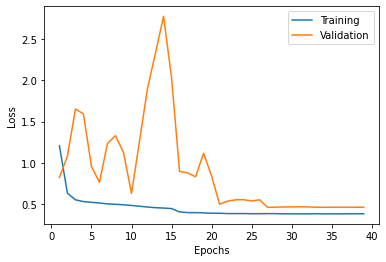

In [8]:
x_plot = list(range(1, len(history.history['val_accuracy']) + 1))
plot_history(history, x_plot, name="_plot.png")

In [11]:
score = cnn.cnn.evaluate(test_dataset)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

19/19 [==============================] - 1s 39ms/step - loss: 0.3467 - accuracy: 0.8867
Test Loss: 0.34666329622268677
Test Accuracy: 0.8866666555404663


In [10]:
predictions = cnn.cnn.predict(X_test)   
predictions = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)
plot_confusionMatrix(y_test, predictions, name="_cm.png")

19/19 [==============================] - 1s 41ms/step
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       300
           1       0.87      0.90      0.89       300

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

True Negatives:  261
False Positives:  39
False Negatives:  29
True Positives:  271


In [9]:
cnn.cnn.save("./trained_cnn")

INFO:tensorflow:Assets written to: ./trained_cnn\assets


INFO:tensorflow:Assets written to: ./trained_cnn\assets


## Extract features from train_dataset

In [4]:
cnn.feature_extractor.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 42, 42, 256)       73984     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 21, 21, 256)      0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 19, 19, 64)        1475

In [5]:
path = "../../../dataset/train/"
train_feat, labels, train_paths = cnn.extract_from_folder(path, "jpg", "./cnn_withus_maxpool")  

Extracting CNN features from image ..\..\..\dataset\train\unsavory\5610.jpg...: 100%|██████████| 11280/11280 [12:52<00:00, 14.59it/s]                    
